In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [5]:
import os
import numpy as np
import pandas as pd
import glob

In [6]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('input/train_1', event_prefix))

In [8]:
def get_features(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values

    r = np.sqrt(x**2 + y**2 + z**2)

    x2 = x/r
    y2 = y/r

    r2 = np.sqrt(x**2 + y**2)
    z2 = z/r2
    
    df['x2'] = x2
    df['y2'] = y2
    df['z2'] = z2
    df['r'] = r2
    
    # eta, and phi
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    eta = - np.log(np.tan(theta/2.))
    df['eta'] = eta
    df['phi'] = phi
    
    return df

In [9]:
hits_more = get_features(hits)
hits_more.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,r,eta,phi
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,64.807045,-3.837108,-3.030827
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,55.339748,-3.994889,3.130112
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,83.838287,-3.579932,-3.127959
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,96.461777,-3.439919,-3.056055
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,63.370335,-3.859459,-2.993168


In [10]:
all_info = hits.merge(truth, on='hit_id')

In [10]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [11]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [49]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab17fb44e0>]],
      dtype=object)

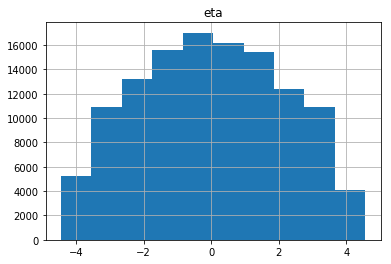

In [8]:
hits_more.hist("eta")

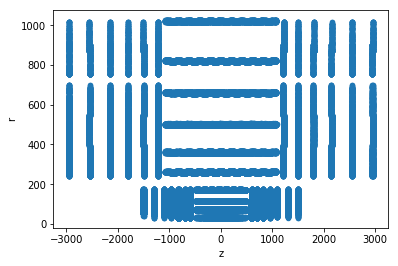

In [9]:
hits_more.plot.scatter(x='z', y='r')

In [12]:
all_info.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,...,-3.837108,-3.030827,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,...,-3.994889,3.130112,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,...,-3.579932,-3.127959,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,...,-3.439919,-3.056055,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,...,-3.859459,-2.993168,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [11]:
pp = all_info[all_info['particle_id'] != 0]['particle_id']
truth_pp = all_info[all_info['weight'] > 1E-7]['particle_id']

In [12]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=200)

In [13]:
def track_view(numb=10, tmp_pp=None):
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224, projection='polar')
    if tmp_pp is None:
        tmp_pp = truth_pp.sample(numb)
        
    for p in tmp_pp:
        data = all_info[all_info['particle_id'] == p][['r', 'eta', 'phi', 'z']].sort_values(by=['z']).values
        ax1.plot(data[:,3], data[:,0], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax1.scatter(data[:,3], data[:,0], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        ax1.xaxis.set_minor_locator(loc)
        

        ax2.plot(data[:,3], data[:,1], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax2.scatter(data[:,3], data[:,1], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        ax2.xaxis.set_minor_locator(loc)

        ax3.plot(np.abs(data[:,3]), data[:,2], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax3.scatter(np.abs(data[:,3]), data[:,2], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        ax3.xaxis.set_minor_locator(loc)
        
        ax4.plot(data[:,2], np.abs(data[:,3]), '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax4.scatter(data[:,2], np.abs(data[:,3]), marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        


    ax1.set_xlabel("Z")
    ax1.set_ylabel("r")
    ax2.set_xlabel("Z")
    ax2.set_ylabel("eta")
    ax3.set_xlabel("Z")
    ax3.set_ylabel("phi")
    ax4.grid(True)
    if len(tmp_pp) < 12:
        ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    plt.show()
    return tmp_pp

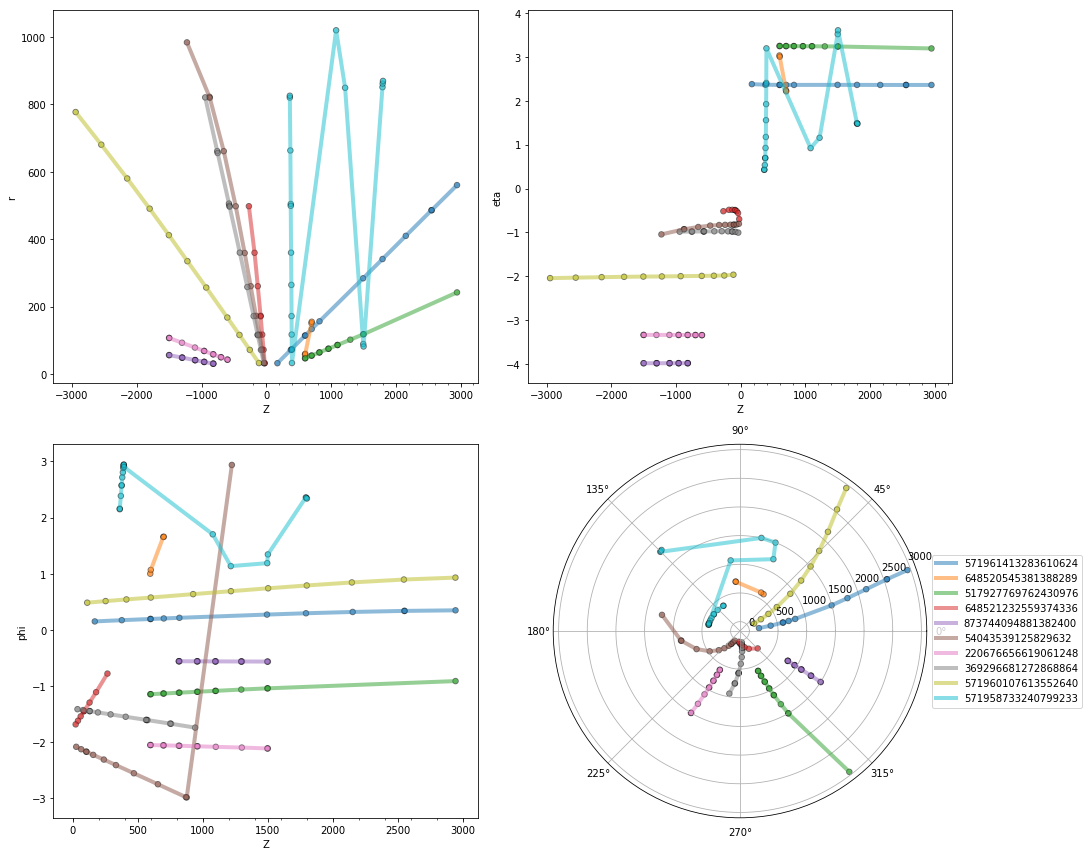

In [16]:
pp10 = track_view(numb=10, tmp_pp=pp10)

In [22]:
def pick_event(pID):
    return all_info[all_info['particle_id'] == pID]

In [17]:
pp10

103087    571961413283610624
51395     648520545381388289
103997    517927769762430976
74021     648521232559374336
574       873744094881382400
35224      54043539125829632
233       220676656619061248
19833     369296681272868864
105040    571960107613552640
76894     571958733240799233
Name: particle_id, dtype: int64

In [14]:
def plot_one(p):
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224, projection='polar')        
    
    data = all_info[all_info['particle_id'] == p][['r', 'eta', 'phi', 'z']].sort_values(by=['z']).values
    ax1.plot(data[:,3], data[:,0], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax1.scatter(data[:,3], data[:,0], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax1.xaxis.set_minor_locator(loc)


    ax2.plot(data[:,3], data[:,1], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax2.scatter(data[:,3], data[:,1], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax2.xaxis.set_minor_locator(loc)

    ax3.plot(np.abs(data[:,3]), data[:,2], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax3.scatter(np.abs(data[:,3]), data[:,2], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax3.xaxis.set_minor_locator(loc)

    ax4.plot(data[:,2], np.abs(data[:,3]), '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax4.scatter(data[:,2], np.abs(data[:,3]), marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        


    ax1.set_xlabel("Z")
    ax1.set_ylabel("r")
    ax2.set_xlabel("Z")
    ax2.set_ylabel("eta")
    ax3.set_xlabel("Z")
    ax3.set_ylabel("phi")
    ax4.grid(True)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    plt.show()

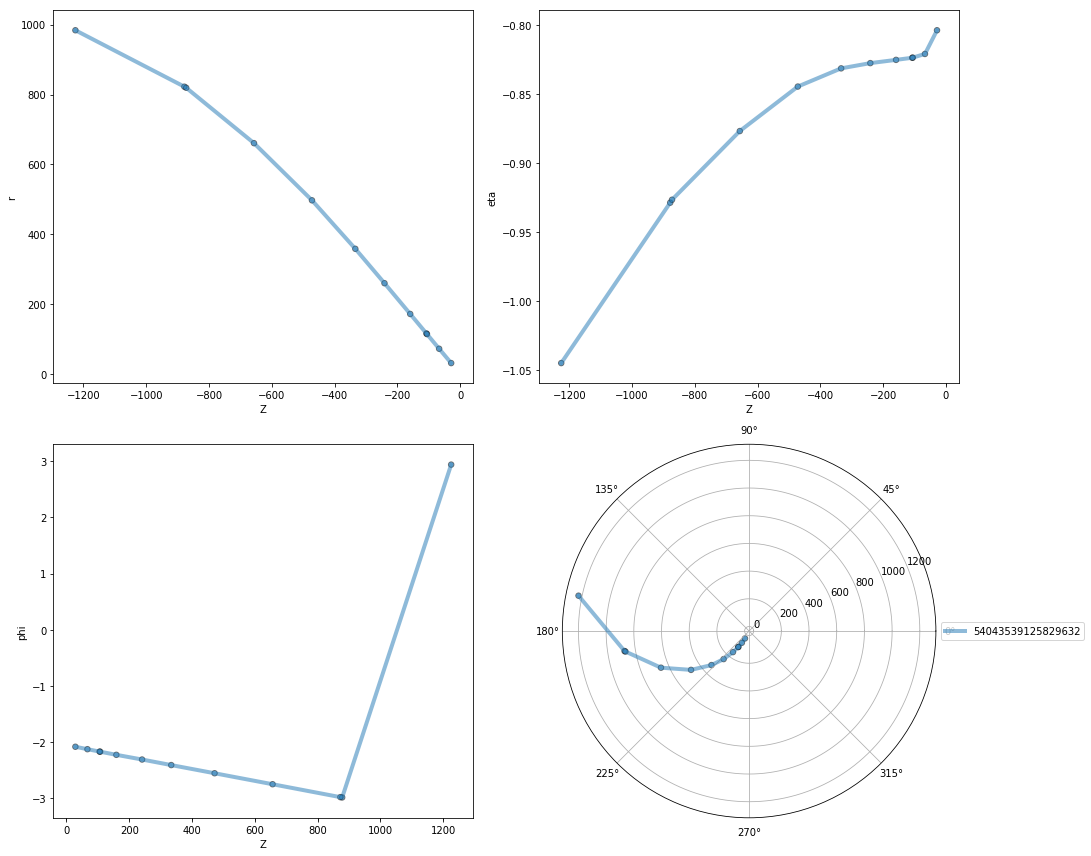

In [25]:
plot_one(54043539125829632)

It's likely a cosmic ray event: 571958733240799233

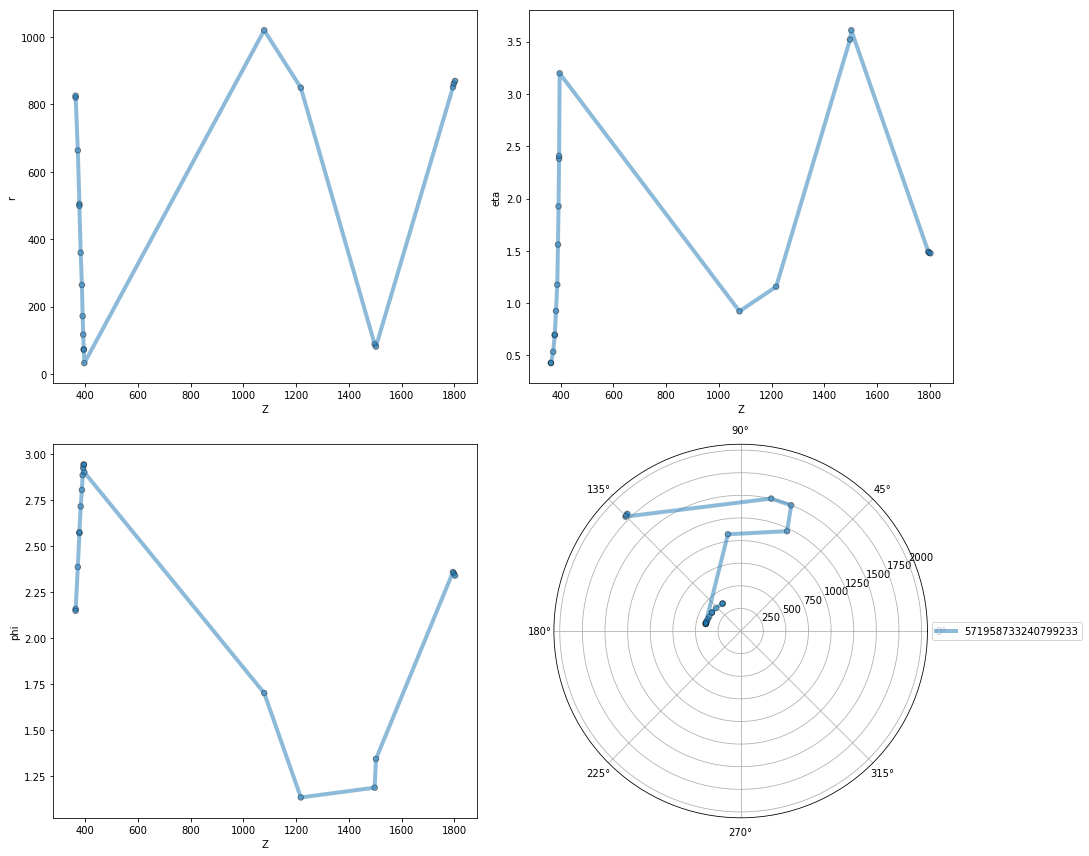

In [21]:
plot_one(571958733240799233)

In [24]:
jj = pick_event(571958733240799233)
jj.sort_values(by=['z'])

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
111508,111509,-454.644989,682.195984,363.399994,17,2,1782,-0.506994,0.760746,0.443272,...,0.429906,2.158644,571958733240799233,-454.632996,682.202026,364.273010,0.103403,0.269528,-0.005823,0.000002
111505,111506,-450.983002,691.254028,363.399994,17,2,1781,-0.500082,0.766511,0.440293,...,0.427182,2.148866,571958733240799233,-451.069000,691.216980,364.078003,0.110141,0.266722,-0.006710,0.000002
95697,95698,-482.671997,454.574005,371.799988,13,8,1518,-0.634960,0.597997,0.560758,...,0.534886,2.386165,571958733240799233,-482.683014,454.565002,371.821991,-0.033966,0.287777,-0.009925,0.000002
89953,89954,-423.989014,272.894989,377.799988,13,6,1163,-0.672938,0.433128,0.749275,...,0.692567,2.569704,571958733240799233,-423.985992,272.898010,377.884003,-0.141869,0.253651,-0.009243,0.000003
89956,89957,-420.919006,267.531006,377.799988,13,6,1164,-0.672736,0.427583,0.757503,...,0.699139,2.575416,571958733240799233,-420.920013,267.528992,378.066010,-0.145782,0.251545,-0.008532,0.000004
83589,83590,-327.625000,148.880997,382.600006,13,4,837,-0.623752,0.283448,1.063173,...,0.925346,2.715065,571958733240799233,-327.622986,148.884003,382.880005,-0.220938,0.208438,-0.009605,0.000004
76894,76895,-249.283997,87.321297,387.399994,13,2,598,-0.531661,0.186235,1.466672,...,1.176133,2.804661,571958733240799233,-249.283997,87.321198,386.958008,-0.256560,0.164136,-0.012502,0.000005
45721,45722,-166.063995,43.623402,390.091003,8,8,1011,-0.389634,0.102353,2.271958,...,1.559040,2.884706,571958733240799233,-166.063995,43.622200,390.071014,-0.283252,0.116871,-0.010947,0.000005
39635,39636,-114.166000,25.316401,392.227997,8,6,675,-0.278937,0.061855,3.354117,...,1.924852,2.923373,571958733240799233,-114.166000,25.318001,392.230988,-0.294418,0.088418,-0.013848,0.000006
33011,33012,-72.217903,14.627500,394.252991,8,4,416,-0.180059,0.036470,5.350564,...,2.378970,2.941750,571958733240799233,-72.217903,14.627400,394.238007,-0.301338,0.063352,-0.015625,0.000007


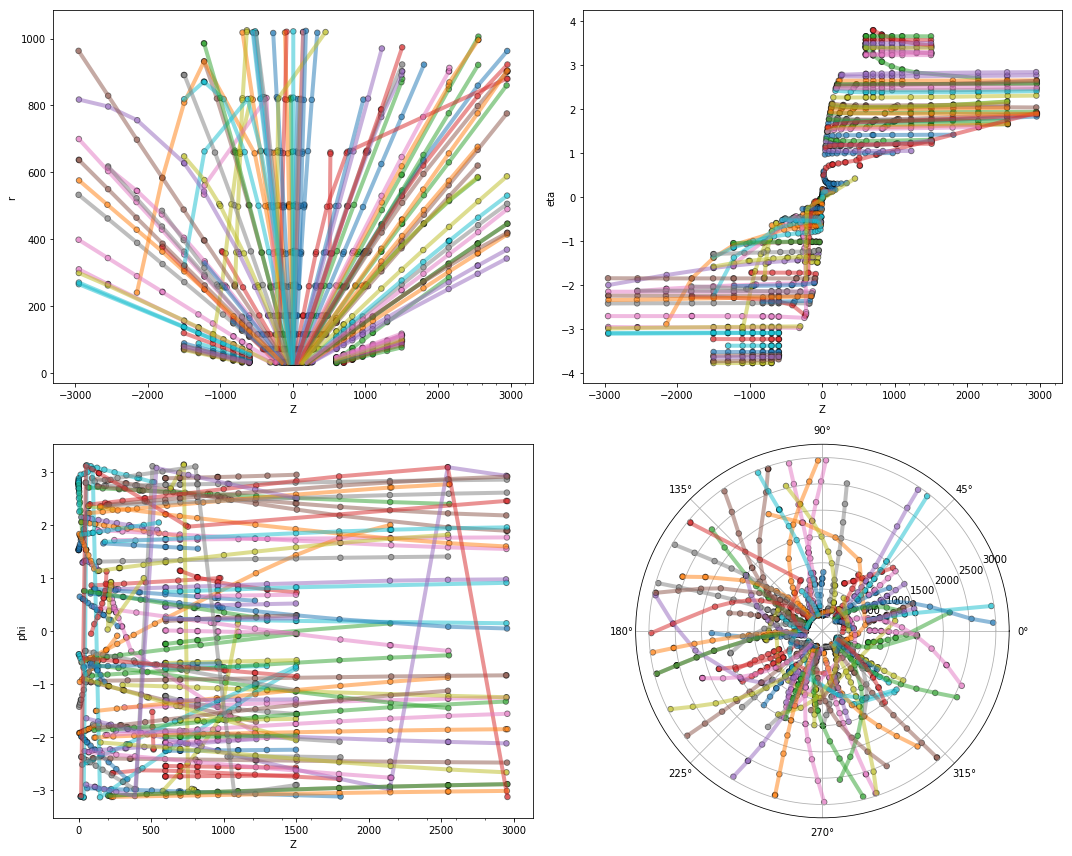

In [31]:
pp100 = track_view(tmp_pp=pp100)

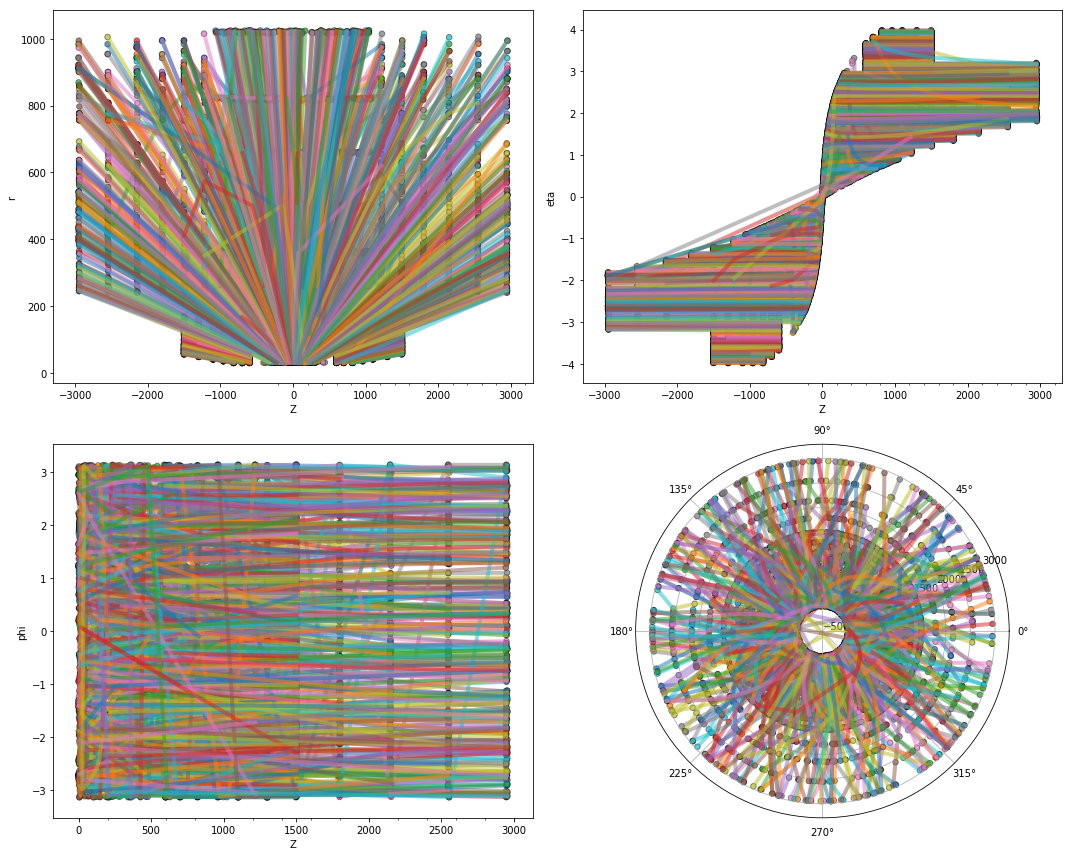

In [33]:
pp1000 = track_view(numb=1000)

In [15]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [24]:
max_charge = cells.groupby('hit_id').agg({'value': np.max})

,value
hit_id,
1,0.211723
2,0.334087
3,0.099964
4,0.323907
5,0.296566


In [25]:
max_chargeCP = max_charge.copy()

In [ ]:
max_chargeCP.reindex(index=np.arange(len(max_chargeCP)), columns=)

In [22]:
pd.concat([max_charge, cells], axis=1, join='outer', keys=['hit_id', 'value'])

hit_id   value                      
           value  hit_id   ch0   ch1     value
0            NaN       1   209   617  0.013832
1       0.211723       1   210   617  0.079887
2       0.334087       1   209   618  0.211723
3       0.099964       2    68   446  0.334087
4       0.323907       3    58   954  0.034005
5       0.296566       3    58   956  0.007798
6       0.289269       3    60   951  0.019897
7       0.304021       3    58   955  0.099964
8       0.287819       3    59   952  0.065576
9       0.329157       3    60   952  0.018697
10      0.236652       3    59   953  0.094193
11      0.282262       3    59   954  0.063372
12      0.141562       4   181  1181  0.323907
13      0.289050       5   256   590  0.296566
14      0.238345       6   241   489  0.289269
15      0.301006       7   103   779  0.304021
16      0.346271       8   284   613  0.287819
17      0.266380       9   232  1205  0.329157
18      0.263555      10    91  1071  0.236652
19      0.256336      10    91  1070  0.003647
20      0.302139      11    88   516  0.282262
21      0.304183      12   314   236  0.056201
22      0.311924      12   313   237  0.141562
23      0.235710      12   313   236  0.110228
24      0.204115      13     1   748  0.289050
25      0.194511      14   105   595  0.057594
26      0.327002      14   105   594  0.238345
27      0.261243      15   133   595  0.301006
28      0.306440      16   179   489  0.346271
29      0.273500      17   146  1199  0.266380
...          ...     ...   ...   ...       ...
664966       NaN  120925   634     7  1.000000
664967       NaN  120926   813     6  1.000000
664968       NaN  120926   816     7  1.000000
664969       NaN  120926   815     7  1.000000
664970       NaN  120926   814     7  1.000000
664971       NaN  120926   814     6  1.000000
664972       NaN  120926   812     6  1.000000
664973       NaN  120927   995     5  1.000000
664974       NaN  120928   568     6  1.000000
664975       NaN  120929  1098     2  1.000000
664976       NaN  120929  1097     2  1.000000
664977       NaN  120929  1093     2  1.000000
664978       NaN  120929  1096     2  1.000000
664979       NaN  120929  1095     2  1.000000
664980       NaN  120929  1094     2  1.000000
664981       NaN  120930   901     9  1.000000
664982       NaN  120930   902     9  1.000000
664983       NaN  120931   449     2  1.000000
664984       NaN  120931   450     2  1.000000
664985       NaN  120932   631     0  1.000000
664986       NaN  120932   632     0  1.000000
664987       NaN  120933   210     6  1.000000
664988       NaN  120933   211     6  1.000000
664989       NaN  120934   655     5  1.000000
664990       NaN  120935   547     1  1.000000
664991       NaN  120936   122     5  1.000000
664992       NaN  120936   123     5  1.000000
664993       NaN  120937   430    11  1.000000
664994       NaN  120938   260     7  1.000000
664995       NaN  120939   134     5  1.000000

[664996 rows x 5 columns]

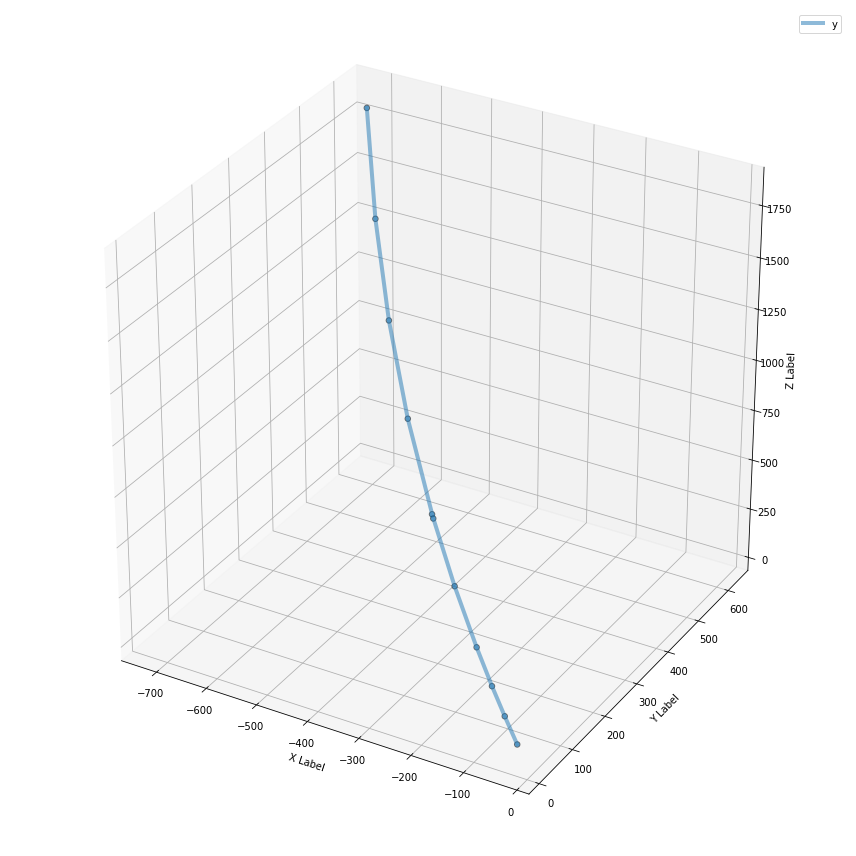

In [48]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.x, data.y, data.z, '-', alpha=0.5, lw=4)
ax.scatter(data.x, data.y, data.z, marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
#ax.view_init(elev=90, azim=0)
ax.legend()

fig.tight_layout()
plt.show()

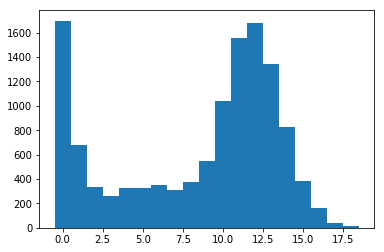

In [55]:
plt.hist(particles[particles['particle_id'] != 0]['nhits'], bins=[x-0.5 for x in range(0, 20)])
plt.show()

In [68]:
len(particles[particles['particle_id']!= 0])

12263

In [70]:
hits.shape

(120939, 7)

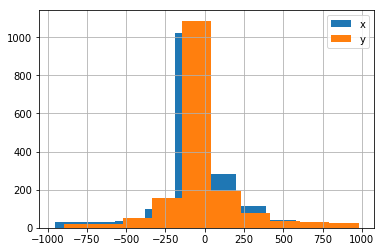

In [62]:
plt.hist(particles[particles['nhits'] == 0]['vx'], label='x')
plt.hist(particles[particles['nhits'] == 0]['vy'], label='y')
#plt.hist(particles[particles['nhits'] == 0]['vz'], label='z')
plt.legend()
plt.grid()
plt.show()

In [63]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [65]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ['NN', 'V', 'DET', "NN"])
]

In [66]:
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
        
print(word_to_ix)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [67]:
tag_to_ix = {"DET": 0, "NN": 1, 'V': 2}
embedding_dim = 6
hidden_dim = 6

In [71]:
tags = ["DET", "NN", "V", "DET", "NN"]
target = prepare_sequence(tags, tag_to_ix)
print(target)

tensor([ 0,  1,  2,  0,  1])


In [97]:
pp = particles[(particles['particle_id'] != 0) & (particles['nhits'] > 6)].sample(2)['particle_id']
print(pp)

3460    225192282154860544
6654    540433810710331392
Name: particle_id, dtype: int64


In [84]:
embedding = nn.Embedding(90, embedding_dim)
print(prepare_sequence(training_data[0][0], word_to_ix))
embedding(prepare_sequence(training_data[0][0], word_to_ix))

tensor([ 0,  1,  2,  3,  4])


tensor([[ 0.2736, -0.4026,  1.1018,  0.8074,  1.9880, -0.3079],
        [-0.1436, -0.3819,  2.6041, -1.8029, -0.7182,  2.0660],
        [-1.1298, -0.1038,  0.8289,  1.2761,  0.9106, -0.7103],
        [-0.0394,  1.3060,  0.4647, -0.8308, -2.0834, -0.8277],
        [ 0.7782, -0.8451,  0.8532, -0.2744, -0.7622,  0.1582]])

In [93]:
pp.iloc[0]

4506417125916672

In [98]:
all_info[all_info['particle_id']==pp.iloc[0]]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
22000,22001,11.049000,-29.442499,68.850800,8,2,117,225192282154860544,11.044800,-29.444000,68.853699,0.098946,-0.235565,0.604068,0.000009
23805,23806,11.241000,-29.899900,70.023102,8,2,133,225192282154860544,11.237200,-29.901199,70.026497,0.099036,-0.235201,0.604141,0.000008
23860,23861,12.123800,-31.989500,75.400597,8,2,134,225192282154860544,12.123300,-31.990000,75.397697,0.100143,-0.235338,0.603860,0.000007
31610,31611,28.078199,-65.295502,162.212006,8,4,298,225192282154860544,28.084700,-65.292503,162.216003,0.121015,-0.226305,0.602874,0.000006
31622,31623,28.922300,-66.857399,166.386993,8,4,299,225192282154860544,28.924700,-66.855598,166.384003,0.121909,-0.226139,0.602693,0.000005
38688,38689,51.419498,-103.667999,267.570007,8,6,537,225192282154860544,51.412201,-103.672997,267.571014,0.144545,-0.212297,0.602130,0.000005
45535,45536,85.868103,-148.335999,398.358002,8,8,962,225192282154860544,85.868401,-148.335999,398.368988,0.171109,-0.194467,0.600449,0.000004
45539,45540,87.139397,-149.763000,402.803009,8,8,963,225192282154860544,87.133797,-149.768005,402.798004,0.172522,-0.193454,0.600331,0.000004
77296,77297,158.410995,-213.764008,624.119995,13,2,654,225192282154860544,158.404007,-213.766998,624.216003,0.209483,-0.151914,0.598353,0.000003
77307,77308,152.639999,-209.548996,607.500000,13,2,655,225192282154860544,152.666000,-209.533005,607.760986,0.207369,-0.155558,0.598222,0.000003


In [102]:
train1 = all_info[all_info['particle_id']==pp.iloc[1]][['x', 'y', 'z']]

In [107]:
train1_tensor = torch.from_numpy(train1.values)
print(train1_tensor)

tensor([[  13.4408,   28.9720,    0.6906],
        [  14.5282,   31.1657,    0.6906],
        [  13.2252,   28.5263,    0.6594],
        [  14.2829,   30.6836,    0.7156],
        [  32.3045,   64.3608,    0.9156],
        [  32.0521,   63.9259,    0.8844],
        [  55.4264,  100.9600,    1.1656],
        [  89.3630,  146.2590,    1.5594],
        [ 155.3400,  215.5720,    1.8000],
        [ 150.5790,  211.2240,    1.8000],
        [ 365.7410,  341.6600,    4.2000],
        [ 545.4040,  378.3470,    5.4000],
        [ 539.1130,  377.9400,    5.4000],
        [ 739.6850,  359.5510,    5.4000],
        [ 995.5260,  226.2090,    5.4000]])


In [116]:
inp = nn.Linear(3, hidden_dim)

In [122]:
F.log_softmax(train1_tensor, dim=1)

tensor([[ -15.5312,   -0.0000,  -28.2814],
        [ -16.6375,   -0.0000,  -30.4751],
        [ -15.3011,   -0.0000,  -27.8669],
        [ -16.4007,   -0.0000,  -29.9680],
        [ -32.0563,   -0.0000,  -63.4452],
        [ -31.8738,   -0.0000,  -63.0415],
        [ -45.5336,    0.0000,  -99.7944],
        [ -56.8960,    0.0000, -144.6996],
        [ -60.2320,    0.0000, -213.7720],
        [ -60.6450,    0.0000, -209.4240],
        [  -0.0000,  -24.0810, -361.5410],
        [   0.0000, -167.0570, -540.0040],
        [   0.0000, -161.1730, -533.7130],
        [   0.0000, -380.1340, -734.2850],
        [   0.0000, -769.3170, -990.1260]])

In [123]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        ##self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings = nn.Linear(3, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden
        )
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [152]:
embedding_dim = 6
hidden_dim = 6
total_hits = 30
total_tracks = 3
model = LSTMTagger(embedding_dim, hidden_dim, total_hits, total_tracks)

In [126]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [127]:
with torch.no_grad():
    inputs = train1_tensor
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[-1.1842, -0.7774, -1.4506],
        [-1.2065, -0.7557, -1.4650],
        [-1.2230, -0.7522, -1.4509],
        [-1.2243, -0.7523, -1.4493],
        [-1.1674, -0.7708, -1.4864],
        [-1.1669, -0.7713, -1.4862],
        [-1.1248, -0.7950, -1.4975],
        [-1.1062, -0.8065, -1.5016],
        [-1.1028, -0.8087, -1.5023],
        [-1.1028, -0.8087, -1.5023],
        [-1.1027, -0.8088, -1.5023],
        [-1.1023, -0.9501, -1.2687],
        [-1.1165, -0.9857, -1.2060],
        [-1.2723, -1.6559, -0.6369],
        [-1.2734, -1.6583, -0.6355]])


In [135]:
all_pps = np.unique(particles['particle_id'])
particle_id_map = {all_pps[x]:x for x in range(len(all_pps))}

In [149]:
def tag_hits(seq, to_tag):
    idxs = [to_tag[w[0]] for w in seq.values]
    print(idxs)
    return torch.tensor(idxs, dtype=torch.long)

In [138]:
train1 = all_info[all_info['particle_id']==pp.iloc[1]][['particle_id', 'x', 'y', 'z']]

In [150]:
train1_tag = tag_hits(train1, particle_id_map)

[6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657]


In [151]:
len(train1_tag)

15

In [153]:
append1 = all_info.sample(total_hits - len(train1_tag))[['particle_id', 'x', 'y', 'z']]

In [159]:
t1 = train1.append(append1)
tag1 = 

30